In [513]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [514]:
def f(x):
    return 3*x**2 - 4*x + 5

In [515]:
f(3.0)

20.0

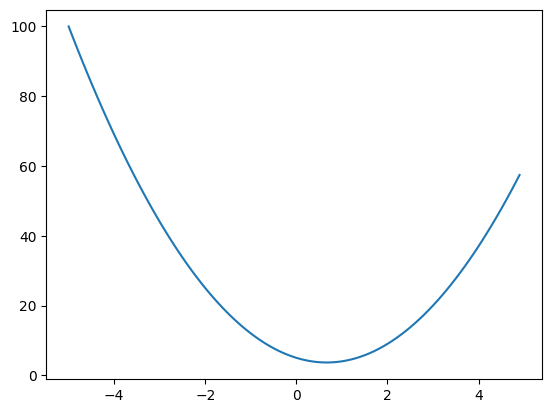

In [516]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [517]:
h = 0.00000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [518]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [519]:
h = 0.00000000001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)  
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.000000000009999
slope 0.9999112648984011


In [520]:
class Value:
    def __init__(self, data, _prev=(), _op='', label=None):
        self.data = data
        self.grad = 0.0
        self._prev = set(_prev)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad

        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        out = Value(-self.data, (self,), 'neg')

        def _backward():
            self.grad += -1.0*out.grad

        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + -other
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = self * (other**-1)
        return out


    def __pow__(self, other):
        assert isinstance(other, (int, float)
                        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Value(math.tanh(self.data), (self,), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2)*out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += out.data*out.grad

        out._backward = _backward
        return out
      
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L.grad = 1.0


In [521]:
from graphviz import Digraph


def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges


def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={
                'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (
        n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name=uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

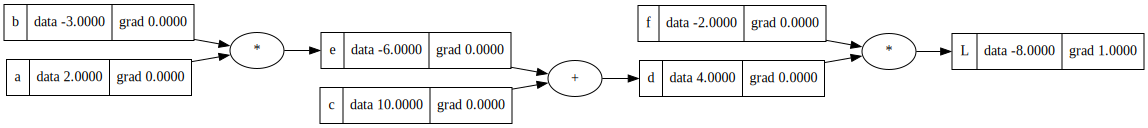

In [522]:
draw_dot(L)

In [523]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()


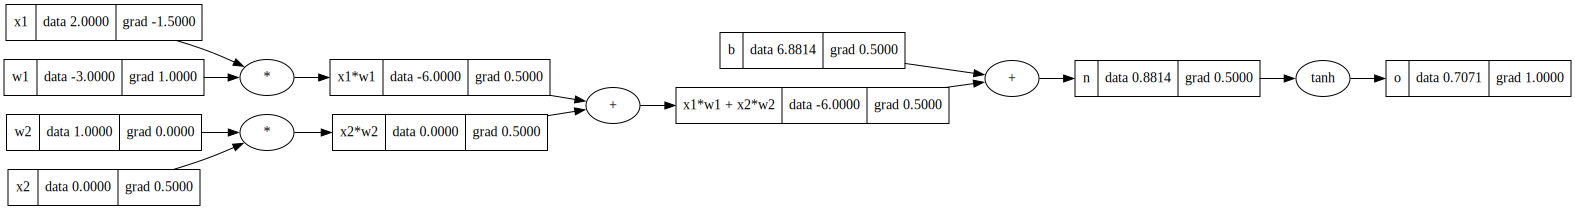

In [524]:
draw_dot(o)

In [525]:
import torch

In [526]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------')
print('x1', x1.grad.data.item())
print('x2', x2.grad.data.item())
print('w1', w1.grad.data.item())
print('w2', w2.grad.data.item())


0.7071066904050358
------
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [527]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [528]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.27539754386532517)

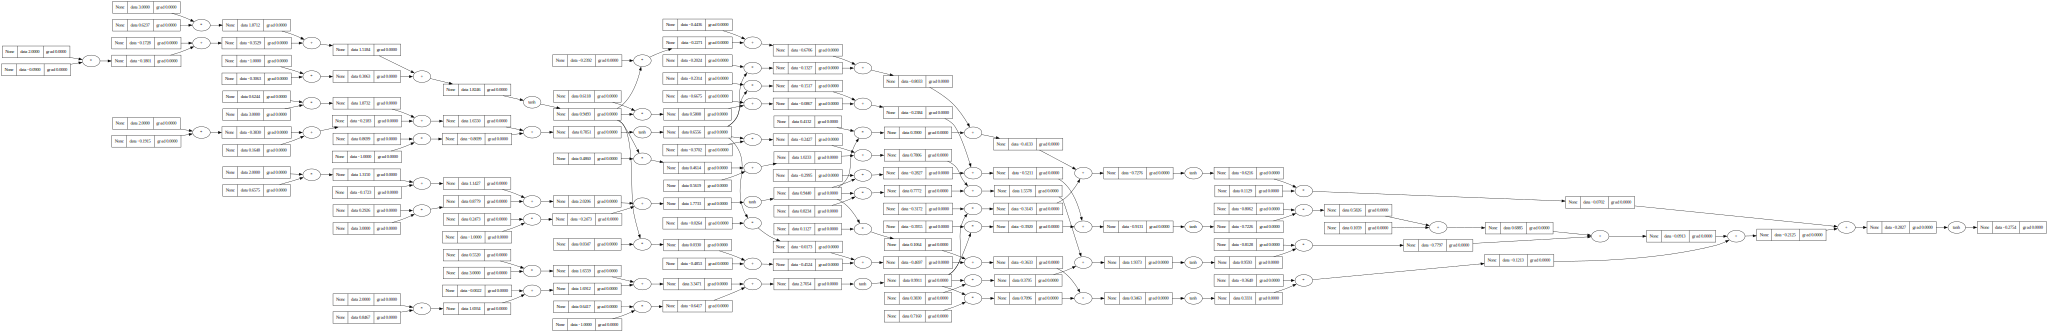

In [529]:
draw_dot(n(x))

In [530]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.27539754386532517),
 Value(data=0.012851089128299681),
 Value(data=0.008760294679433801),
 Value(data=-0.2513010886548858)]

In [531]:
for k in range(1000):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)


0 5.235857970236728
1 4.463714736367031
2 4.08609516148697
3 3.7777853842265854
4 3.4706540579656027
5 3.138163975197495
6 2.773156405595436
7 2.3788553767177585
8 1.9633840863815295
9 1.5469214400764213
10 1.169041550578943
11 0.8666785606367626
12 0.6472577298251405
13 0.49488430155448215
14 0.3892219715779246
15 0.3144714281430876
16 0.26014267131217145
17 0.21957106686409122
18 0.18851418648211452
19 0.16421674421417023
20 0.14484211761561067
21 0.12913309432810163
22 0.11620744267444022
23 0.10543207752531421
24 0.09634360612887788
25 0.0885968372922509
26 0.08193057875792814
27 0.07614440083719834
28 0.07108252885875255
29 0.06662247540976635
30 0.06266688844699306
31 0.05913762108458245
32 0.055971361143901874
33 0.05311637169699538
34 0.05053003337063323
35 0.048176972205274796
36 0.046027619903812794
37 0.044057096654347
38 0.04224433691674209
39 0.04057139986475557
40 0.0390229213658652
41 0.03758567532495412
42 0.03624822017880813
43 0.03500061217165944
44 0.0338341713677441

In [532]:
ypred

[Value(data=0.9827071272402745),
 Value(data=-0.9909778923614354),
 Value(data=-0.9817591970873095),
 Value(data=0.9906766269043672)]